In [1]:
!pip install --quiet tensorflow_text==2.11.*

In [50]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np

In [3]:
df=pd.read_csv("https://raw.githubusercontent.com/codebasics/deep-learning-keras-tf-tutorial/master/47_BERT_text_classification/spam.csv")

In [4]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [7]:
df_ham=df[df["Category"]=="ham"].sample(747)
df_spam=df[df["Category"]=="spam"]

In [8]:
final_df=pd.concat([df_ham,df_spam],axis=0)

In [9]:
final_df.shape

(1494, 2)

In [10]:
final_df.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham          747    740  I cant pick the phone right now. Pls send a me...   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham         2  
spam        4

In [11]:
final_df["Category"].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

In [12]:
final_df["Category"]=final_df["Category"].apply(lambda x:1 if x=="spam" else 0)

In [13]:
final_df.head()

,Category,Message
2488,0,K ill drink.pa then what doing. I need srs mod...
3285,0,ALRITE SAM ITS NIC JUST CHECKIN THAT THIS IS U...
2752,0,Play w computer? Aiyah i tok 2 u lor?
4482,0,No..its ful of song lyrics..
3970,0,Thanks for your message. I really appreciate y...


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train,X_test,y_train,y_test=train_test_split(final_df[["Message"]],final_df[["Category"]],test_size=0.2,stratify=final_df["Category"])

In [16]:
y_train.value_counts()

Category
1           598
0           597
Name: count, dtype: int64

In [17]:
y_test.value_counts()

Category
0           150
1           149
Name: count, dtype: int64

In [18]:
X_train.head(3)

,Message
4154,URGENT!! Your 4* Costa Del Sol Holiday or £500...
4874,Lol! Oops sorry! Have fun.
2064,"URGENT! Your mobile No *********** WON a £2,00..."


In [19]:
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/2" # @param {type: "string"} ["https://tfhub.dev/google/experts/bert/wiki_books/2", "https://tfhub.dev/google/experts/bert/wiki_books/mnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qqp/2", "https://tfhub.dev/google/experts/bert/wiki_books/squad2/2", "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2",  "https://tfhub.dev/google/experts/bert/pubmed/2", "https://tfhub.dev/google/experts/bert/pubmed/squad2/2"]
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [25]:
  preprocess_model=hub.KerasLayer(PREPROCESS_MODEL)
  bert_model=hub.KerasLayer(BERT_MODEL)

In [31]:
#Bert layer
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name="text")
preprocessed_text=preprocess_model(text_input)
output=bert_model(preprocessed_text)

#Nueral network layers
l=tf.keras.layers.Dropout(0.1,name="Dropout")(output["pooled_output"])
l=tf.keras.layers.Dense(1,activation="sigmoid",name="output")(l)

#Constuct final model
model=tf.keras.Model(inputs=[text_input],outputs=[l])


In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [44]:
model.compile(optimizer="adam",loss="BinaryCrossentropy",metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision()])

In [45]:
model.fit(X_train,y_train) #Ran for 1 epoch because taking so much of time

38/38 [==============================] - 366s 9s/step - loss: 0.6079 - binary_accuracy: 0.6720


In [46]:
model.evaluate(X_test,y_test)

10/10 [==============================] - 91s 9s/step - loss: 0.5030 - binary_accuracy: 0.7860


[0.5030410885810852, 0.785953164100647]

In [48]:
y_pred=model.predict(X_test)

10/10 [==============================] - 95s 9s/step


In [51]:
y_pred_output=np.where(y_pred>0.5,1,0)

In [60]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Text(50.722222222222214, 0.5, 'Truth')

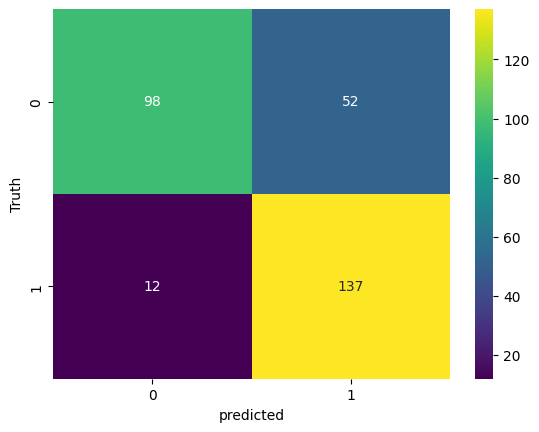

In [61]:
sns.heatmap(confusion_matrix(y_test,y_pred_output),fmt="d",annot=True,cmap="viridis")
plt.xlabel("predicted")
plt.ylabel("Truth")